选择地标：东京塔

# 灰色预测模型对样本较少的东京风险值（索赔率）进行简单预测

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import random

from matplotlib.ticker import ScalarFormatter  # 导入ScalarFormatter

from scipy.stats import linregress
from scipy.linalg import eig

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持显示中文
plt.rcParams['axes.unicode_minus'] = False  # 支持显示负号
warnings.filterwarnings("ignore")  # 忽略警告信息，使输出更清洁


In [360]:
# 使用之前计算得到的调整后年度风险值
risk_dict = {
    2013: 0.0218,
    2014: 0.0226,
    2015: 0.0237,
    2016: 0.0227,
    2017: 0.0259,
    2018: 0.0230,
    2019: 0.0250,
    2020: 0.0257,
    2021: 0.0262,
    2022: 0.0269,
    2023: 0.0271
}

# 准备数据
years = np.array(list(range(2013, 2024))).reshape(-1, 1)  # 年份作为自变量
risk_values_corrected = np.array(list(risk_dict.values()))  # 使用正确的风险值列表作为因变量

# 创建线性回归模型
model = LinearRegression()
model.fit(years, risk_values_corrected)  # 使用更正后的风险值重新训练模型

# 预测未来五年，2024-2028年
future_years = np.array([[2024], [2025], [2026], [2027], [2028]])
predicted_risk = model.predict(future_years)  # 重新预测未来五年的风险值

# 格式化预测结果为四位小数
predicted_risk = np.round(predicted_risk, 4)

# 将更正后的预测结果转换为字典格式，方便查看
predicted_risk_dict = dict(zip(range(2024, 2029), predicted_risk))


In [193]:
risk_dict.update(predicted_risk_dict)

risk_df = pd.DataFrame(list(risk_dict.items()), columns=['Year', 'Risk'])

print(risk_df)

    Year    Risk
0   2013  0.0218
1   2014  0.0226
2   2015  0.0237
3   2016  0.0227
4   2017  0.0259
5   2018  0.0230
6   2019  0.0250
7   2020  0.0257
8   2021  0.0262
9   2022  0.0269
10  2023  0.0271
11  2024  0.0277
12  2025  0.0282
13  2026  0.0287
14  2027  0.0292
15  2028  0.0297


## 未来五年东京风险预测值画图

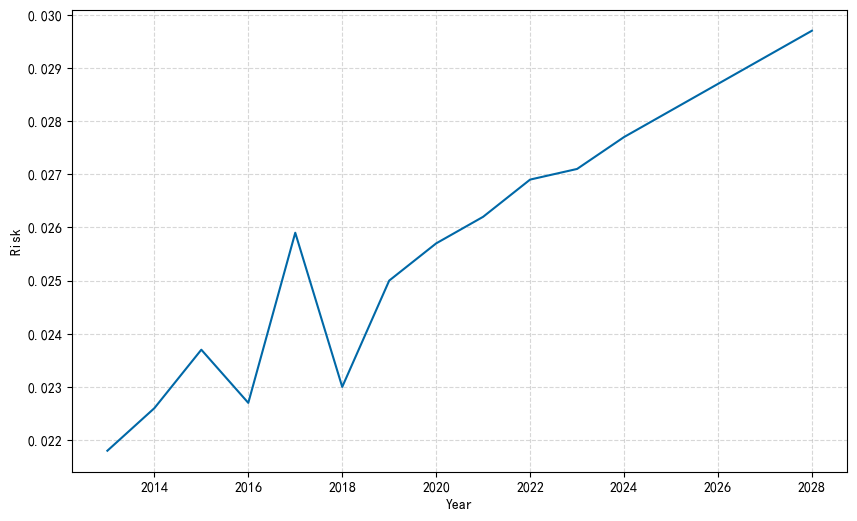

In [350]:
import matplotlib.pyplot as plt

# Data
years = risk_df['Year']
risk_values = risk_df['Risk']

# Splitting the risk values into two groups based on the year
risk_values_before_24 = risk_values[:12]
risk_values_after_24 = risk_values[12:]

# Creating two lists of colors based on the year
colors_before_24 = ['#0068A7'] * 12
colors_after_24 = ['#00A28E'] * 4

# Combine the colors
colors = colors_before_24 + colors_after_24

# Create the line plot with different colors
plt.figure(figsize=(10, 6))
plt.plot(years, risk_values, linestyle='-', color='#0068A7')

plt.xlabel('Year')
plt.ylabel('Risk')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('tokyo risk.png', dpi=500,)
# Show the plot
plt.show()


# 保险模型对担保东京塔预估，这里特化了赔付金为3000w，保单数为1

In [64]:
# 参数范围设定
P_range = (1000000, 5000000)
Ca_range = [30000000]
i_values = [0.02, 0.03, 0.04]
Cf_range = (850000, 1000000)
Cv_range = (80, 100)
t_range = [2, 3, 4,5,6,7,8,9,10]
Q_range = [1]
rc = 0.0269

# 种群大小、交叉率和变异率
population_size = 150
crossover_rate = 0.7
mutation_rate = 0.08
generations = 2000

def initialize_population():
    # 增加一个维度来代表Q的值
    return np.random.rand(population_size, 7)

def decode_chromosome(chromosome):
    P = int(np.round(P_range[0] + (P_range[1] - P_range[0]) * chromosome[0]))
    Ca = Ca_range[0]
    i = i_values[int(np.floor(chromosome[2] * len(i_values)))]  # 选择i的离散值
    Cf = int(np.round(Cf_range[0] + (Cf_range[1] - Cf_range[0]) * chromosome[3]))
    Cv = int(np.round(Cv_range[0] + (Cv_range[1] - Cv_range[0]) * chromosome[4]))
    t = int(np.round(t_range[0] + (t_range[1] - t_range[0]) * chromosome[5]))
    Q = Q_range[0]
    return P, Ca, i, Cf, Cv, t, Q  # 返回包括Q的值

def fitness_function(chromosome):
    P, Ca, i, Cf, Cv, t, Q = decode_chromosome(chromosome)  # 使用解码后的Q值
    profit = P * Q - (Cf + Cv * Q) - rc * Ca * Q * (1 / (1 + i)**t)
    return profit if profit > 0 else 0

def roulette_wheel_selection(population, fitness):
    total_fitness = np.sum(fitness)
    if total_fitness == 0:
        selection_probabilities = np.ones(len(population)) / len(population)  # 如果总适应度为零，均匀分配概率
    else:
        selection_probabilities = fitness / total_fitness
    selected_indices = np.random.choice(np.arange(len(population)), size=len(population), p=selection_probabilities)
    return population[selected_indices]


def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    else:
        return parent1, parent2

def mutate(chromosome):
    mutated_chromosome = chromosome.copy()
    for i in range(len(chromosome)):
        if np.random.rand() < mutation_rate:
            mutated_chromosome[i] = np.random.rand()
    return mutated_chromosome

def genetic_algorithm():
    population = initialize_population()
    global_best_fitness = -np.inf
    global_best_solution = None
    for generation in range(generations):
        fitness = np.array([fitness_function(chrom) for chrom in population])
        best_index = np.argmax(fitness)
        if fitness[best_index] > global_best_fitness:
            global_best_fitness = fitness[best_index]
            global_best_solution = population[best_index].copy()
        population = roulette_wheel_selection(population, fitness)
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = population[i], population[i+1]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            offspring.append(child1)
            offspring.append(child2)
        population = np.array(offspring)
    return global_best_solution, global_best_fitness

best_solution, best_fitness = genetic_algorithm()
P, Ca, i, Cf, Cv, t, Q = decode_chromosome(best_solution)
print(f"最优解的参数: P={P}, Ca={Ca}, i={i}, Cf={Cf}, Cv={Cv}, t={t}, Q={Q}")
print(f"最优解的利润: {best_fitness}")


最优解的参数: P=4999750, Ca=30000000, i=0.04, Cf=850665, Cv=84, t=3, Q=1
最优解的利润: 3431580.9385525715


得到每年保险价格P = 500w

# AHP对年度收入预估（功能价值力、旅游价值力、文化价值力）

In [9]:
judgment_matrix = np.array([
    [1, 2, 3],
    [1/2, 1, 1/2],
    [1/3, 2, 1]
])

In [10]:
eigenvalues, eigenvectors = eig(judgment_matrix)

# 提取最大特征值及其对应的特征向量
max_eigenvalue = np.max(eigenvalues)
max_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]

# 计算一致性指标CI
n = len(judgment_matrix)
CI = (max_eigenvalue - n) / (n - 1)

# 随机一致性指标RI
RI_dict = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45}
RI = RI_dict[n]

# 计算一致性比率CR
CR = CI / RI

print("特征向量:", max_eigenvalue)
print("特征值:", max_eigenvector)
print("CI:", CI)
print("RI:", RI)
print("CR:", CR)

特征向量: (3.1356108446580477+0j)
特征值: [0.86024636+0.j 0.29823076+0.j 0.41356331+0.j]
CI: (0.06780542232902387+0j)
RI: 0.58
CR: (0.11690590056728253+0j)


## 得出权重，统计收入

In [11]:
# 归一化特征向量以得到权重
weights = max_eigenvector / np.sum(max_eigenvector)
weights = weights.real
# 输出权重
print("权重:", weights)

权重: [0.54721643 0.18970934 0.26307422]


In [314]:
# 权重（从之前的计算中获得）
weights = np.array([0.54721643, 0.18970934, 0.26307422])

# 估算每个因素的价值（可以是货币单位或百分比）
functional = 20000000  # 功能价值力估算为2000万
tourism = 10000000  # 旅游价值力估算为1000万
historical = 5000000  # 文化价值力估算为500万

# 计算建筑每年带来的收入
W = (
    weights[0] * functional +
    weights[1] * tourism +
    weights[2] * historical
)

print('预计东京塔每年收入',W)

预计东京塔每年收入 14156793.1


# 利润公式以及画图（2028之后的rc因为预测不再准确而统一采用平均值0.026）

In [362]:
W = 14156793.1
P = 5000000
Ca = 30000000

rc = 0.026
t =  50

i = 10 * rc 

Rc = 0.01 * W * t + P * t + (1 + i) ** t

Profit = W * t - Rc + rc * Ca * t 
Profit

489656900.0875084

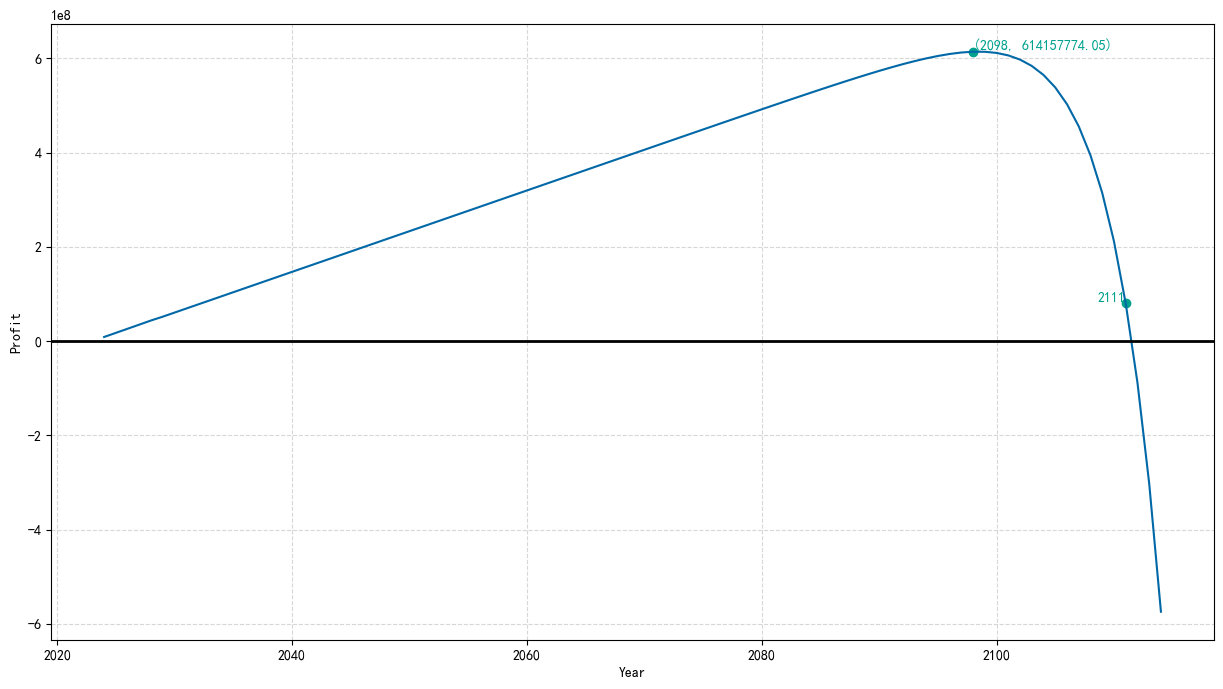

In [356]:
# Assume risk_dict and other variables are already defined as per previous context
# Define the long-term profit calculation function with updated parameters
def calculate_long_term_profit(year, rc):
    t = year - 2023  # Base year is 2023, so t starts from 1 in 2024
    i = 10 * rc  # Adjusted weather aging index calculation
    Rc = 0.01 * W * t + P * t + (1 + i) ** t  # Total cost
    Profit = W * t - Rc + rc * Ca * t  # Profit calculation
    return Profit

# Calculate profits from 2024 to 2123
long_term_years = list(range(2024, 2115))
long_term_profits = [calculate_long_term_profit(year, risk_dict[year]) for year in long_term_years]

# Find the year with the maximum profit
max_profit = max(long_term_profits)
max_profit_year = long_term_years[long_term_profits.index(max_profit)]

# Find the last year before profits drop below zero
zero_profit_years = [year for year, profit in zip(long_term_years, long_term_profits) if profit <= 0]
year_before_zero_profit = zero_profit_years[0] - 1 if zero_profit_years else None

# Plotting the graph with specified adjustments
plt.figure(figsize=(15, 8))
plt.plot(long_term_years, long_term_profits, color='#0068A7', linestyle='-')  # Profit curve without markers

# Highlighting the maximum profit year with its coordinates
plt.scatter([max_profit_year], [max_profit], color='#00A28E')  # Highlight max profit year
plt.text(max_profit_year, max_profit, f'({max_profit_year}, {max_profit:.2f})', color='#00A28E', ha='left', va='bottom')

years_with_profit = [year for year, profit in zip(long_term_years, long_term_profits) if profit > 0]
last_profit_year = max(years_with_profit) if years_with_profit else None


if last_profit_year:
    plt.scatter([last_profit_year], [long_term_profits[long_term_years.index(last_profit_year)]], color='#00A28E')  # Highlight last profit year
    plt.text(last_profit_year, long_term_profits[long_term_years.index(last_profit_year)], f'{last_profit_year}', color='#00A28E', verticalalignment='bottom', horizontalalignment='right')


# Adjusting the x-axis to a black solid line
plt.axhline(0, color='black', linewidth=2)  # X-axis in black
plt.xlabel('Year')
plt.ylabel('Profit')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('tokyo porofit.png', dpi=500,)
plt.show()


## 由此可见，2098年左右东京塔收益开始迅速下降，最多到2111年左右东京塔不再盈利，应该进行转移或重建保护。

## 转移后收入，也是用层次分析法的权重

In [351]:
functional = 20000000  # 功能价值力估算为2000万
tourism = 8000000  # 旅游价值力估算为1000万
historical = 2000000  # 文化价值力估算为500万

In [352]:
W_ = (
    weights[0] * functional +
    weights[1] * tourism +
    weights[2] * historical
)

print('预计东京塔转移后每年收入',W_)

预计东京塔转移后每年收入 12988151.76
